In [1]:
# Imports
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
from pycbc import psd, tmpltbank
from pycbc.tmpltbank import metricParameters
from pycbc import psd
import pandas as pd
from IPython.display import display_html
import numpy
import multiprocessing
from itertools import repeat
from matplotlib import pyplot as plt

In [2]:
# Settings

seed=13
fUpper = 2048

# aligo Parameters
aligo_td_length = 2048 # seconds
aligo_srate = 4096 # Hz
aligo_f_low = 10.0 # Hz
aligo_N = int(aligo_td_length * aligo_srate)
aligo_fd_length = int(aligo_N / 2 + 1)
aligo_delta_t = 1.0 / aligo_srate
aligo_delta_f = 1.0 / aligo_td_length


# ce Parameters
ce_td_length = 2048 # seconds
ce_srate = 4096 # Hz
ce_f_low = 7.0 # Hz
ce_N = int(ce_td_length * ce_srate)
ce_fd_length = int(ce_N / 2 + 1)
ce_delta_t = 1.0 / ce_srate
ce_delta_f = 1.0 / ce_td_length

In [3]:
# Read the PSDs
aligo_psd = psd.aLIGOZeroDetHighPower(aligo_fd_length, aligo_delta_f, aligo_f_low)
ce_psd = psd.read.from_txt('./template_bank/download/ce_strain/cosmic_explorer_strain.txt', length=ce_fd_length, delta_f=ce_delta_f, low_freq_cutoff=ce_f_low, is_asd_file=True)

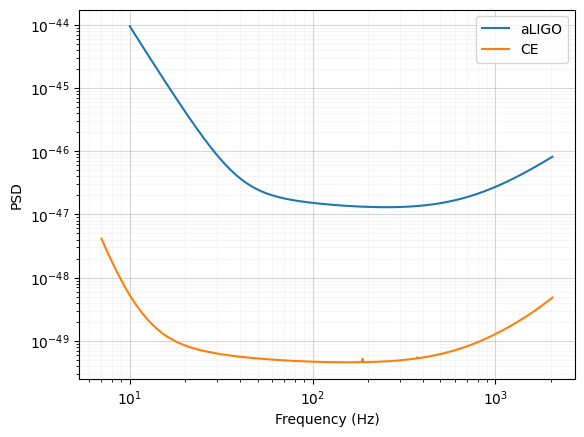

In [4]:
# Plot PSDs

aligo_nz = numpy.logical_and(abs(aligo_psd) > 0, aligo_psd.sample_frequencies > aligo_f_low)
ce_nz = numpy.logical_and(abs(ce_psd) > 0, ce_psd.sample_frequencies > ce_f_low)

plt.loglog(aligo_psd.sample_frequencies[aligo_nz], aligo_psd[aligo_nz], label='aLIGO')
plt.loglog(ce_psd.sample_frequencies[ce_nz], ce_psd[ce_nz], label='CE')
plt.grid(visible=True, which='minor', axis='both', alpha=0.1)
plt.grid(visible=True, which='major', axis='both', alpha=0.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.show()
plt.close()

### General functions for calculating moments. Taken directly from the pycbc source and simplified.

In [5]:
def calculate_moment(psd_f, psd_amp, fmin, fmax, f0, funct, key, norm=None):
    """
    Function for calculating one of the integrals used to construct a template
    bank placement metric. The integral calculated will be

    \int funct(x) * (psd_x)**(-7./3.) * delta_x / PSD(x)

    where x = f / f0. The lower frequency cutoff is given by fmin, see
    the parameters below for details on how the upper frequency cutoff is
    chosen. (eq 2.24 in https://arxiv.org/pdf/gr-qc/9511032.pdf)

    Parameters
    -----------
    psd_f : numpy.array
        numpy array holding the set of evenly spaced frequencies used in the PSD
    psd_amp : numpy.array
        numpy array holding the PSD values corresponding to the psd_f
        frequencies
    fmin : float
        The lower frequency cutoff used in the calculation of the integrals
        used to obtain the metric.
    fmax : float
        The upper frequency cutoff used in the calculation of the integrals
        used to obtain the metric. This can be varied (see the vary_fmax
        option below).
    f0 : float
        This is an arbitrary scaling factor introduced to avoid the potential
        for numerical overflow when calculating this. Generally the default
        value (70) is safe here. **IMPORTANT, if you want to calculate the
        ethinca metric components later this MUST be set equal to f_low.**
    funct : Lambda function
        The function to use when computing the integral as described above.
    norm : Dictionary of floats
        If given then moment[f_cutoff] will be divided by norm[f_cutoff]

    Returns
    --------
    moment : Dictionary of floats
        moment[f_cutoff] will store the value of the moment at the frequency
        cutoff given by f_cutoff.
    """

    # Must ensure deltaF in psd_f is constant
    psd_x = psd_f / f0
    deltax = psd_x[1] - psd_x[0]

    mask = numpy.logical_and(psd_f > fmin, psd_f < fmax)
    comps_red = psd_x[mask] ** (-7./3.) * funct(psd_x[mask], f0) * deltax / \
                psd_amp[mask]
    moment = {}
    moment[key] = comps_red.sum()
    if norm:
        moment[key] = moment[key] / norm[key]
    return moment

In [6]:
def mp_moments(new_f, new_amp, flow, fUpper, f0, key):
    """
    This function calculates the moments of the PSDs in parallel.
    """
    # Need I7 first as this is the normalization factor
    moments = {}
    funct = lambda x,f0: 1
    I7 = calculate_moment(new_f, new_amp, \
                            flow, fUpper, f0, funct, key)
    moments['I7']=I7
    for i in [1,4]:
        funct = lambda x,f0: x**((-i+7)/3.)
        res = calculate_moment(new_f, new_amp, \
                                    flow, fUpper, \
                                    f0, funct, key, norm=I7)
        moments['J%d' %(i)] = res  
    return moments

## Varying cutoff frequencies

In [7]:
# Generate log spaced freq array of cutoff frequencies to test

aligo_n_steps = int((fUpper-aligo_f_low)/10)+1
ce_n_steps = int((fUpper-ce_f_low)/10)+1

aligo_x_freqs = numpy.geomspace(aligo_f_low, fUpper, aligo_n_steps)
ce_x_freqs = numpy.geomspace(ce_f_low, fUpper, ce_n_steps)

In [8]:
# Interpolate the PSDs

aligo_psd_f = numpy.arange(len(aligo_psd.data), dtype=float) * aligo_delta_f
aligo_new_f, aligo_new_amp = tmpltbank.calc_moments.interpolate_psd(aligo_psd_f, aligo_psd, aligo_delta_f)

ce_psd_f = numpy.arange(len(ce_psd.data), dtype=float) * ce_delta_f
ce_new_f, ce_new_amp = tmpltbank.calc_moments.interpolate_psd(ce_psd_f, ce_psd.data, ce_delta_f)

In [9]:
# Do all the J moments for the aLIGO and CE PSDs
# Do each of the four tests (varying min + max cutoff for ce + aligo) in parallel.

with multiprocessing.Pool(processes=12) as pool:
    aligo_lowmod_mp_results = pool.starmap(mp_moments, zip(repeat(aligo_new_f), repeat(aligo_new_amp), aligo_x_freqs, repeat(fUpper), repeat(aligo_f_low), aligo_x_freqs))
    aligo_highmod_mp_results = pool.starmap(mp_moments, zip(repeat(aligo_new_f), repeat(aligo_new_amp), repeat(aligo_f_low), aligo_x_freqs,  repeat(aligo_f_low), aligo_x_freqs))
    ce_lowmod_mp_results = pool.starmap(mp_moments, zip(repeat(ce_new_f), repeat(ce_new_amp), ce_x_freqs, repeat(fUpper), repeat(ce_f_low), ce_x_freqs))
    ce_highmod_mp_results = pool.starmap(mp_moments, zip(repeat(ce_new_f), repeat(ce_new_amp), repeat(ce_f_low), ce_x_freqs,  repeat(ce_f_low), ce_x_freqs))

/tmp/ipykernel_105311/2875080238.py:53: RuntimeWarning: invalid value encountered in scalar divide
  moment[key] = moment[key] / norm[key]
/tmp/ipykernel_105311/2875080238.py:53: RuntimeWarning: invalid value encountered in scalar divide
  moment[key] = moment[key] / norm[key]
/tmp/ipykernel_105311/2875080238.py:53: RuntimeWarning: invalid value encountered in scalar divide
  moment[key] = moment[key] / norm[key]


In [10]:
# Restructure the results

def flatten_dicts(inputdict):
    res={'I7':{}, 'J1':{}, 'J4':{}}
    for d in inputdict:
        for key in d:
            res[key].update(d[key])
    return res

aligo_lowmod_mp_results = flatten_dicts(aligo_lowmod_mp_results)
aligo_highmod_mp_results = flatten_dicts(aligo_highmod_mp_results)
ce_lowmod_mp_results = flatten_dicts(ce_lowmod_mp_results)
ce_highmod_mp_results = flatten_dicts(ce_highmod_mp_results)

In [11]:
# Have a quick look at the results

aligo_lowmod_moments_df = pd.DataFrame(aligo_lowmod_mp_results).sample(n=20, random_state=1).sort_index()
aligo_highmod_moments_df = pd.DataFrame(aligo_highmod_mp_results).sample(n=20, random_state=1).sort_index()
ce_lowmod_moments_df = pd.DataFrame(ce_lowmod_mp_results).sample(n=20, random_state=1).sort_index()
ce_highmod_moments_df = pd.DataFrame(ce_highmod_mp_results).sample(n=20, random_state=1).sort_index()

df1_styler = aligo_lowmod_moments_df.style.set_table_attributes("style='display:inline'").set_caption('ALIGO lowmod moments table')
df2_styler = aligo_highmod_moments_df.style.set_table_attributes("style='display:inline'").set_caption('ALIGO highmod moments table')
df3_styler = ce_lowmod_moments_df.style.set_table_attributes("style='display:inline'").set_caption('CE lowmod moments table')
df4_styler = ce_highmod_moments_df.style.set_table_attributes("style='display:inline'").set_caption('CE highmod moments table')
print(f"ALIGO lowmod I7: {aligo_lowmod_moments_df['I7'].values[0]}")
print(f"ALIGO highmod I7: {aligo_highmod_moments_df['I7'].values[0]}")
print(f"CE lowmod I7: {ce_lowmod_moments_df['I7'].values[0]}")
print(f"CE highmod I7: {ce_highmod_moments_df['I7'].values[0]}")
del aligo_lowmod_moments_df['I7'], aligo_highmod_moments_df['I7'], ce_lowmod_moments_df['I7'], ce_highmod_moments_df['I7']
display_html(df1_styler._repr_html_()+df2_styler._repr_html_()+df3_styler._repr_html_()+df4_styler._repr_html_(), raw=True)

ALIGO lowmod I7: 8.142242372381908e+45
ALIGO highmod I7: 1.3193244951811384e+43
CE lowmod I7: 4.913900788083838e+48
CE highmod I7: 3.637982486102245e+46


,J1,J4
11.105636,271.360777,10.350063
13.342723,272.595067,10.391780
16.030443,274.825151,10.465298
20.835510,281.396090,10.673598
22.540405,284.675819,10.774388
27.080879,296.225812,11.117931
28.538719,300.861011,11.251870
31.694063,312.491885,11.580235
38.078423,342.568915,12.390240
61.041397,502.765543,16.167114


In [12]:
# Calculate 1 / sqrt(J1 - J4) for each frequency

aligo_lowmod_results, aligo_highmod_results, ce_lowmod_results, ce_highmod_results = [], [], [], []
for aligo_freq in aligo_x_freqs:
    aligo_lowmod_results.append(1/(numpy.sqrt((aligo_lowmod_mp_results['J1'][aligo_freq] * (2*numpy.pi*aligo_f_low)**2) - (aligo_lowmod_mp_results['J4'][aligo_freq] * (2*numpy.pi*aligo_f_low)))))
    aligo_highmod_results.append(1/(numpy.sqrt((aligo_highmod_mp_results['J1'][aligo_freq] * (2*numpy.pi*aligo_f_low)**2) - (aligo_highmod_mp_results['J4'][aligo_freq] * (2*numpy.pi*aligo_f_low)))))

for ce_freq in ce_x_freqs:
    ce_lowmod_results.append(1/(numpy.sqrt((ce_lowmod_mp_results['J1'][ce_freq] * (2*numpy.pi*ce_f_low)**2) - (ce_lowmod_mp_results['J4'][ce_freq] * (2*numpy.pi*ce_f_low)))))
    ce_highmod_results.append(1/(numpy.sqrt((ce_highmod_mp_results['J1'][ce_freq] * (2*numpy.pi*ce_f_low)**2) - (ce_highmod_mp_results['J4'][ce_freq] * (2*numpy.pi*ce_f_low)))))

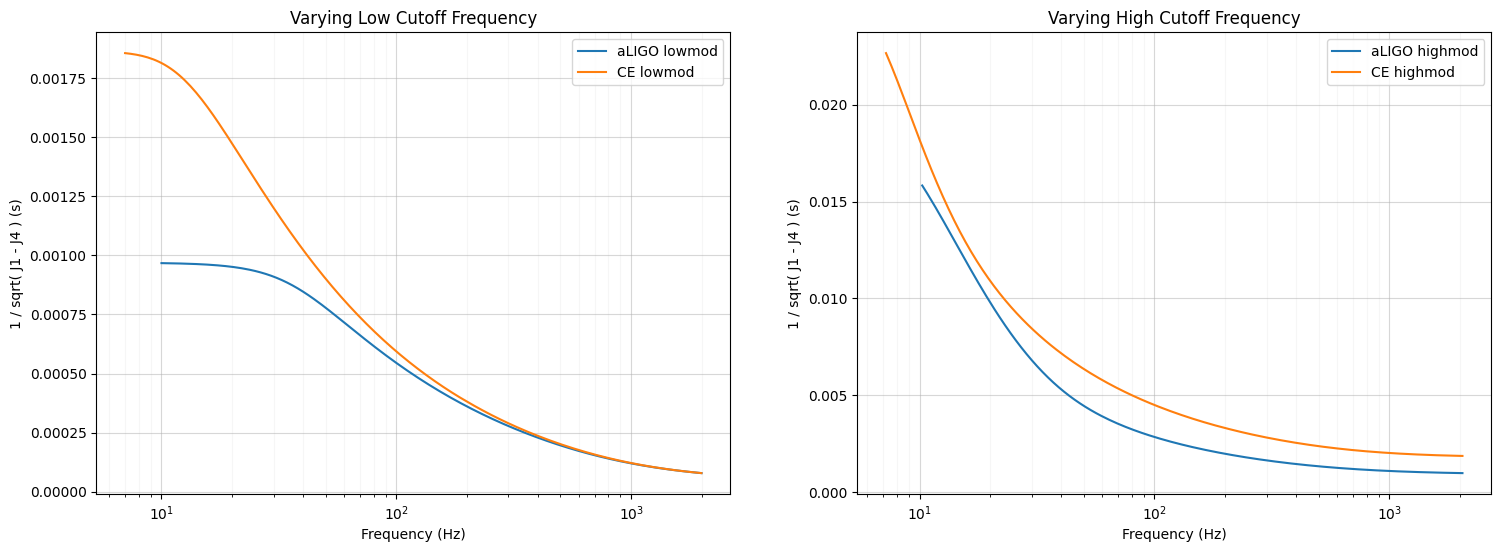

In [13]:
# Plot the results

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax1, ax2 = ax
ax1.plot(aligo_x_freqs, aligo_lowmod_results, label='aLIGO lowmod')
ax1.plot(ce_x_freqs, ce_lowmod_results, label='CE lowmod')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('1 / sqrt( J1 - J4 ) (s)')
ax1.set_xscale('log')
ax1.set_title('Varying Low Cutoff Frequency')
ax1.grid(visible=True, which='minor', axis='both', alpha=0.1)
ax1.grid(visible=True, which='major', axis='both', alpha=0.5)
ax1.legend()
ax2.plot(aligo_x_freqs, aligo_highmod_results, label='aLIGO highmod')
ax2.plot(ce_x_freqs, ce_highmod_results, label='CE highmod')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_xscale('log')
ax2.set_ylabel('1 / sqrt( J1 - J4 ) (s)')
ax2.set_title('Varying High Cutoff Frequency')
ax2.grid(visible=True, which='minor', axis='both', alpha=0.1)
ax2.grid(visible=True, which='major', axis='both', alpha=0.5)
ax2.legend()
fig.show()